# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [5]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [6]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)


In [7]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [8]:
def plotResults(loss_history, train_history, val_history):
    fig, axs = plt.subplots(2)
    fig.set_size_inches(10, 6)

    axs[0].plot(train_history)
    axs[0].plot(val_history)
    axs[0].grid()

    axs[1].plot(loss_history)
    axs[1].grid()

In [9]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, device, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    
    model.to(device)
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if scheduler is not None:
            scheduler.step(ave_loss)
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    correct = 0 
    total = 0 
    with torch.no_grad():
        for i_step, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            prediction = torch.argmax(model(x) , 1)    
            for i in range(len(prediction)):
                if prediction[i] == y[i]:
                    correct += float(1)
            total += float(len(prediction))
            
            del prediction

    return float(correct/total)

In [14]:
loss_history, train_history, val_history = train_model(nn_model, device, train_loader, val_loader, loss, optimizer, 10)

Average loss: 2.325836, Train accuracy: 0.101133, Val accuracy: 0.104566
Average loss: 2.325838, Train accuracy: 0.101133, Val accuracy: 0.104566
Average loss: 2.325822, Train accuracy: 0.101133, Val accuracy: 0.104566
Average loss: 2.325842, Train accuracy: 0.101133, Val accuracy: 0.104566
Average loss: 2.325824, Train accuracy: 0.101133, Val accuracy: 0.104566
Average loss: 2.325836, Train accuracy: 0.101133, Val accuracy: 0.104566
Average loss: 2.325829, Train accuracy: 0.101133, Val accuracy: 0.104566
Average loss: 2.325813, Train accuracy: 0.101133, Val accuracy: 0.104566
Average loss: 2.325819, Train accuracy: 0.101133, Val accuracy: 0.104566
Average loss: 2.325831, Train accuracy: 0.101133, Val accuracy: 0.104566


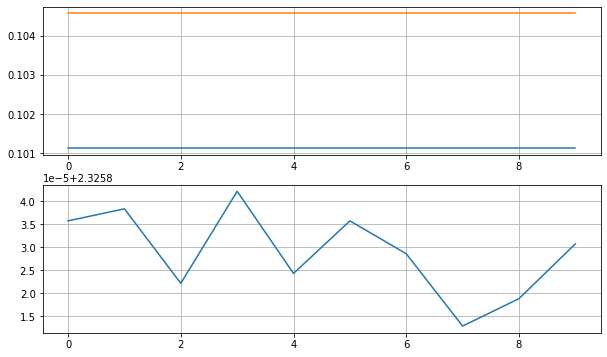

In [15]:
plotResults(loss_history, train_history, val_history)

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [16]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 10))
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, device, train_loader, val_loader, loss, optimizer, 10)

Average loss: 2.157484, Train accuracy: 0.202949, Val accuracy: 0.239984
Average loss: 1.934059, Train accuracy: 0.317681, Val accuracy: 0.380520
Average loss: 1.741883, Train accuracy: 0.409651, Val accuracy: 0.422155
Average loss: 1.689326, Train accuracy: 0.432021, Val accuracy: 0.436352
Average loss: 1.672059, Train accuracy: 0.440569, Val accuracy: 0.441199
Average loss: 1.659644, Train accuracy: 0.447753, Val accuracy: 0.429049
Average loss: 1.655106, Train accuracy: 0.449237, Val accuracy: 0.428162
Average loss: 1.649065, Train accuracy: 0.452923, Val accuracy: 0.445430
Average loss: 1.645293, Train accuracy: 0.454885, Val accuracy: 0.448775
Average loss: 1.643591, Train accuracy: 0.456779, Val accuracy: 0.449799


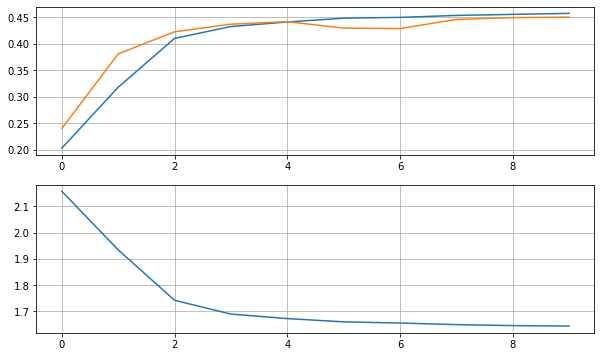

In [17]:
plotResults(loss_history, train_history, val_history)

Добавьте слой с Batch Normalization

In [18]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
            nn.BatchNorm1d(10))

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, device, train_loader, val_loader, loss, optimizer, 10)

Average loss: 1.812815, Train accuracy: 0.416084, Val accuracy: 0.598457
Average loss: 1.398690, Train accuracy: 0.620636, Val accuracy: 0.682616
Average loss: 1.299860, Train accuracy: 0.668549, Val accuracy: 0.709986
Average loss: 1.248750, Train accuracy: 0.693905, Val accuracy: 0.713535
Average loss: 1.218488, Train accuracy: 0.710013, Val accuracy: 0.716675
Average loss: 1.190175, Train accuracy: 0.720933, Val accuracy: 0.739949
Average loss: 1.170009, Train accuracy: 0.732178, Val accuracy: 0.753600
Average loss: 1.153519, Train accuracy: 0.737467, Val accuracy: 0.722613
Average loss: 1.139025, Train accuracy: 0.742791, Val accuracy: 0.768889
Average loss: 1.120389, Train accuracy: 0.749138, Val accuracy: 0.731759


In [ ]:
plotResults(loss_history, train_history, val_history)

Добавьте уменьшение скорости обучения по ходу тренировки.

In [ ]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
            nn.BatchNorm1d(10))
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= True)

loss_history, train_history, val_history = train_model(nn_model, device, train_loader, val_loader, loss, optimizer, 10, sheduler)

In [ ]:
plotResults(loss_history, train_history, val_history)

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [ ]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices, device):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    with torch.no_grad():
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=len(indices),
                                             sampler=SubsetSampler(indices))
        for i, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)

            model_prediction = model(x)
            number_predictions = torch.argmax(model_prediction, dim=1)
            ground_truth = y
                                                  
    return number_predictions.detach().cpu().numpy(), ground_truth.detach().cpu().numpy()

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices, device)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

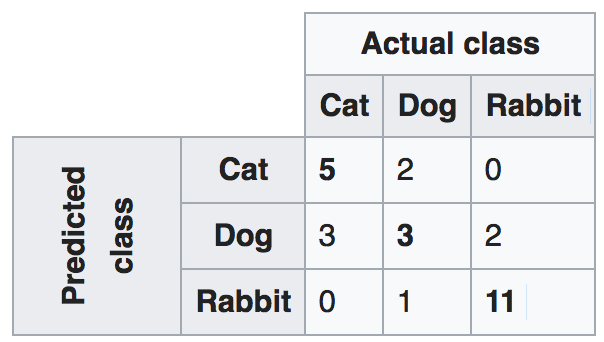

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

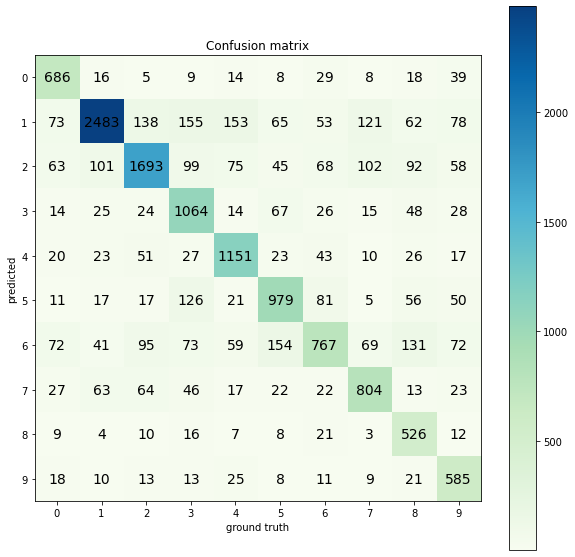

In [67]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    size = 10
    confusion_matrix = np.zeros((size,size), int)
    for i in range(predictions.shape[0]):
        confusion_matrix[predictions[i]][ground_truth[i]] += 1
    
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

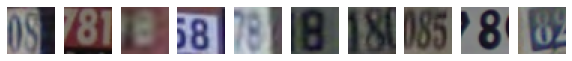

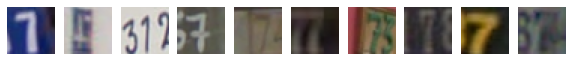

In [80]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    confused_images = np.where((predictions == predicted_class) & (groud_truth == gt_class))
    visualize_images(val_indices[confused_images], data)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [81]:
# Experiment here!

In [98]:
model_1 = nn.Sequential(
            nn.Conv2d(3, 3, 3, stride=1, padding = 1),
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
            nn.BatchNorm1d(10))
optimizer = optim.Adam(model_1.parameters(), lr=1e-2, weight_decay=1e-3)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= True)

loss_history, train_history, val_history = train_model(model_1, device, train_loader, val_loader, loss, optimizer, 15, sheduler)

Average loss: 1.513489, Train accuracy: 0.502031, Val accuracy: 0.660160
Average loss: 1.179647, Train accuracy: 0.632597, Val accuracy: 0.686779
Average loss: 1.117514, Train accuracy: 0.654267, Val accuracy: 0.699065
Average loss: 1.097404, Train accuracy: 0.659250, Val accuracy: 0.712579
Average loss: 1.089214, Train accuracy: 0.662134, Val accuracy: 0.717767
Average loss: 1.082121, Train accuracy: 0.664352, Val accuracy: 0.690328
Average loss: 1.080548, Train accuracy: 0.666058, Val accuracy: 0.705276
Average loss: 1.077594, Train accuracy: 0.667781, Val accuracy: 0.710054
Average loss: 1.078089, Train accuracy: 0.668379, Val accuracy: 0.716879
Average loss: 1.068328, Train accuracy: 0.670853, Val accuracy: 0.705959
Average loss: 1.068775, Train accuracy: 0.667252, Val accuracy: 0.714081
Average loss: 1.063667, Train accuracy: 0.673156, Val accuracy: 0.703092
Average loss: 1.063456, Train accuracy: 0.671825, Val accuracy: 0.732510
Average loss: 1.055964, Train accuracy: 0.674265, V

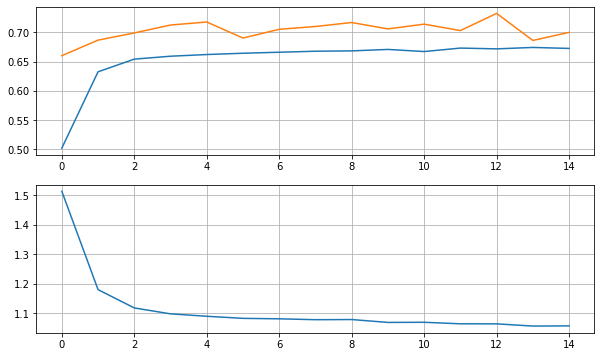

In [100]:
plotResults(loss_history, train_history, val_history)#эх нужно лучше

Average loss: 1.225739, Train accuracy: 0.612053, Val accuracy: 0.775169
Average loss: 0.905440, Train accuracy: 0.728782, Val accuracy: 0.767047
Average loss: 0.864782, Train accuracy: 0.739992, Val accuracy: 0.784656
Average loss: 0.856048, Train accuracy: 0.743627, Val accuracy: 0.783837
Average loss: 0.847739, Train accuracy: 0.746749, Val accuracy: 0.784588
Average loss: 0.837178, Train accuracy: 0.751152, Val accuracy: 0.783496
Average loss: 0.828212, Train accuracy: 0.755537, Val accuracy: 0.791960
Average loss: 0.827446, Train accuracy: 0.752960, Val accuracy: 0.785339


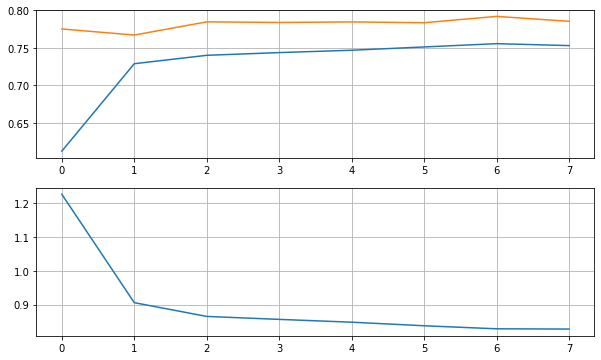

In [110]:
model_2 = nn.Sequential(
            nn.Conv2d(3, 3, 3, stride=1, padding = 1),
            Flattener(),
            nn.BatchNorm1d(3*32*32),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
            nn.BatchNorm1d(10))

optimizer = optim.Adam(model_2.parameters(), lr=1e-2, weight_decay=1e-3)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= True)

loss_history, train_history, val_history = train_model(model_2, device, train_loader, val_loader, loss, optimizer, 8, sheduler)
plotResults(loss_history, train_history, val_history)#чего-то я намудрил на самом деле, что с точность валидации?
#модель застряла

In [114]:
model_3 = nn.Sequential(
            nn.Conv2d(3, 3, 3, stride=1, padding = 1),
            Flattener(),
            nn.BatchNorm1d(3*32*32),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
            nn.BatchNorm1d(10))

optimizer = optim.Adam(model_3.parameters(), lr=1e-4, weight_decay=2.5*1e-2)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.05)

loss_history, train_history, val_history = train_model(model_3, device, train_loader, val_loader, loss, optimizer, 50, sheduler)

c:\users\neo\appdata\local\programs\python\python38\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Average loss: 1.628611, Train accuracy: 0.502406, Val accuracy: 0.685755
Average loss: 1.267237, Train accuracy: 0.665546, Val accuracy: 0.730189
Average loss: 1.153885, Train accuracy: 0.712470, Val accuracy: 0.742338
Average loss: 1.082696, Train accuracy: 0.734703, Val accuracy: 0.778650
Average loss: 1.029454, Train accuracy: 0.751254, Val accuracy: 0.781721
Average loss: 0.986883, Train accuracy: 0.762584, Val accuracy: 0.788752
Average loss: 0.953878, Train accuracy: 0.770024, Val accuracy: 0.799672
Average loss: 0.923645, Train accuracy: 0.779050, Val accuracy: 0.803631
Average loss: 0.897409, Train accuracy: 0.786694, Val accuracy: 0.808068
Average loss: 0.876005, Train accuracy: 0.790670, Val accuracy: 0.811685
Average loss: 0.855001, Train accuracy: 0.797120, Val accuracy: 0.810115
Average loss: 0.836151, Train accuracy: 0.803075, Val accuracy: 0.816327
Average loss: 0.817792, Train accuracy: 0.808910, Val accuracy: 0.830865
Average loss: 0.798018, Train accuracy: 0.816196, V

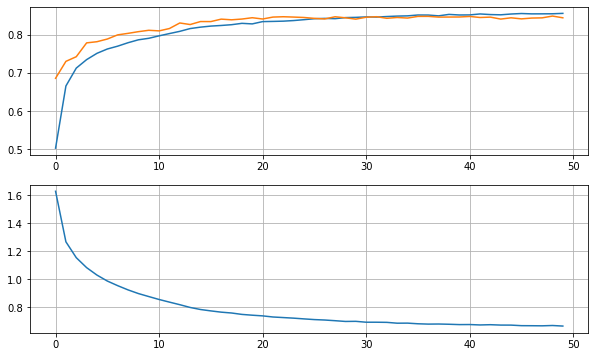

In [116]:
plotResults(loss_history, train_history, val_history)#повезло повезло

In [117]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(model_3, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8249


In [12]:
model_4 = nn.Sequential(
            nn.Conv2d(3, 3, 3, stride=1),
            Flattener(),
            nn.BatchNorm1d(3*32*32),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
            nn.BatchNorm1d(10))

optimizer = optim.Adam(model_4.parameters(), lr=1e-4, weight_decay=2.5*1e-2)
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.05)

loss_history, train_history, val_history = train_model(model_4, device, train_loader, val_loader, loss, optimizer, 15, sheduler)
plotResults(loss_history, train_history, val_history)#повезло повезло

RuntimeError: running_mean should contain 2700 elements not 3072